# Do NBA players 'dissappear' during stretches of games?

Often, people like Bill Simmons say that individual players such as Ben Simmons or Andrew Wiggins 'dissappear' during long stretches of the game. Compare this to two-way players such as Joel Embiid who are consistently active and gunning to do something. The goal of this project was to find a way to quantify and distinguish between two such categories of players.

## Metric 1: Mean number of occurrences in game log

The first metric I tested to determine this was the mean number of occurrences of an individual player in nba game logs divided by the total amount of time the player played. For reference, this is a portion of an nba game log between the Game 7 of the Nuggets vs. Blazers on May 12, 2019.

![alt_text](game_log.png)

Every time an individual player shows up, their occurrences increases by 1. So, in the above game log, Gary Harris's number of occurrences would increase by 2 and Damian Lillard's occurrences would increase by 2. Note that this includes both positive *and* negative impacts the player had during the game. So, Aminu's fouls and turnovers would still increase his occurrences. We include these because we don't want to diminish a player's activity if the activity doesn't have a positive outcome. We want to find players who sit in the corner and dissappear.

### Data Aggregation

Using a Python script, we parse all the game logs for the entire 2018-2019 season and playoffs to this point and find the number of occurrences and time played by each individual player.

In [1]:
import csv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pprint
%matplotlib inline
from scipy.stats import *
import numpy as np

d = {}
with open('activity.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        d[row['player']] = {'time played': int(row['time played']), 'occurrences': int(row['occurrences'])}

activity = {}
time_played = {}
for name in d:
    if d[name]['time played']>100000:
        activity[name] = d[name]['occurrences']/d[name]['time played']
        time_played[name] = d[name]['time played']
y = list(activity.keys())
x = list(activity.values())
df = pd.DataFrame({'player': list(activity.keys()), 'values': list(activity.values()), 
                   'time played': list(time_played.values())})
ordered_df = df.sort_values(by='values')

We will remove players who play below the mean time played to filter out players who rarely play since we want to find big stars who dissappear. Here is what the final data looks like sorted by value.

In [2]:
print(ordered_df)

                player    values  time played
113  Terrance Ferguson  0.012092       127357
158          PJ Tucker  0.012444       196395
110     Reggie Bullock  0.013097       120561
134      Darius Miller  0.013470       109803
62      Garrett Temple  0.013778       129624
..                 ...       ...          ...
165     Thaddeus Young  0.041327       158926
28          Trae Young  0.042267       158990
38        Josh Jackson  0.048369       129193
151         Seth Curry  0.051384       101413
31      Justin Jackson  0.059543       104950

[176 rows x 3 columns]


Additionally, here is a histogram of the values

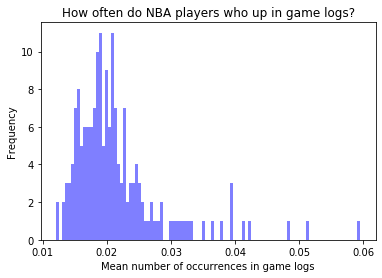

In [3]:
num_bins = 100
n, bins, patches = plt.hist(list(activity.values()), num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Mean number of occurrences in game logs')
plt.ylabel('Frequency')
plt.title('How often do NBA players who up in game logs?')
plt.show()

This does seem like a reasonable metric. We see that '3-and-D' players like Terrance Ferguson and PJ Tucker have a low number of occurrences since they dissappear on most game logs for a long time. Compare this to stars who handle the ball a lot like Justin Jackson, Seth Curry, or Trae Young and constantly are active.

In conclusion, here are the 10 most 'dissappearing' players:

In [4]:
print(ordered_df[:10])

                player    values  time played
113  Terrance Ferguson  0.012092       127357
158          PJ Tucker  0.012444       196395
110     Reggie Bullock  0.013097       120561
134      Darius Miller  0.013470       109803
62      Garrett Temple  0.013778       129624
156      Avery Bradley  0.013903       117963
103   Ryan Arcidiacono  0.013923       119367
111  Langston Galloway  0.014104       119118
19       Austin Rivers  0.014277       139806
44       Nicolas Batum  0.014305       145123


And the 10 most 'active' players:

In [5]:
print(ordered_df[::-1][:10])

                player    values  time played
31      Justin Jackson  0.059543       104950
151         Seth Curry  0.051384       101413
38        Josh Jackson  0.048369       129193
28          Trae Young  0.042267       158990
165     Thaddeus Young  0.041327       158926
85        Monte Morris  0.039578       136693
138        Patty Mills  0.039390       126478
174  Bogdan Bogdanovic  0.039293       118266
59       Marcus Morris  0.037880       143454
25        Jrue Holiday  0.036610       148212


## Metric 2: Finding time between individual actions for all players

The second metric we can use the seconds between an individual player's actions. Recall the game log from above

![alt_text](game_log.png)

Let's take Enes Kanter as an example. Kanter does something (positive or negative) at the following timestamps: 11:28, 10:33, and 10:00. This means that from the periods of 12:00 to 11:28, 11:28 to 10:33, and 10:33 to 10:00 he was not showing up the game log. In other words, he 'dissappeared' for 32, 55, and 33 seconds. We parse the nba game logs for all these 'time deltas' in the 2018-2019 games and plot histograms.

In [6]:
d = {}
with open('activity_distribution.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if ';' in row['time deltas']:
            l = row['time deltas'].split(';')
            if len(l)>2000:
                d[row['player']] = [int(i) for i in np.random.choice(l, 2000)]

Let's take a look at the histograms of Joel Embiid, a very active player, and PJ Tucker a more inactive player.

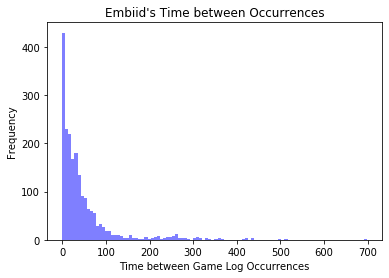

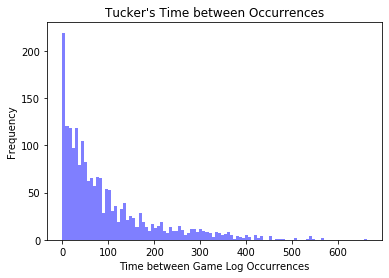

In [7]:
def plot_hist(l, title):
    num_bins = 100
    n, bins, patches = plt.hist(l, num_bins, facecolor='blue', alpha=0.5)
    plt.xlabel('Time between Game Log Occurrences')
    plt.ylabel('Frequency')
    plt.title(f"{title}'s Time between Occurrences")
    plt.show()

plot_hist(d['J.Embiid'], 'Embiid')
plot_hist(d['P.Tucker'], 'Tucker')

Clearly, Tucker's histogram is more evently distributed whereas Embiid's is more consistently in the lower range. A good metric for measuring this 'tail' is skewness. For example, consider the two skewnesses for these two players.

In [8]:
print('Embiid Skewness:', skew(d['J.Embiid']))
print('Tucker Skewness:', skew(d['P.Tucker']))

Embiid Skewness: 3.4222434144154517
Tucker Skewness: 1.7206998895098011


Embiid has a greater skewness and Tucker has a lower skewness. Let's do the same calculation for all players.

In [9]:
y = []
for player in d:
    y_ = skew(d[player])
    y.append(y_)
    
df = pd.DataFrame({'player': list(d.keys()), 'skewness': y})
ordered_df = df.sort_values(by='skewness')
print(ordered_df)

         player  skewness
96   D.Collison  1.630781
3    D.Augustin  1.692694
117    P.Tucker  1.720700
9       J.Grant  1.749987
45      C.Osman  1.814472
..          ...       ...
119   B.Griffin  3.368676
1      J.Embiid  3.422243
88   A.Drummond  3.452683
94      K.Towns  3.530690
52     J.Harden  3.704802

[129 rows x 2 columns]


Once again, this seems like a pretty good metric. High usage players (when on the court) such as Karl-Anthony Towns or Lou Williams show a high skew while lower usage players who 'dissappear' on both ends have a lower skew.

In conclusion, here are the most 'dissappearing' players by time between occurrences in nba game logs.

In [10]:
print(ordered_df[:10])

         player  skewness
96   D.Collison  1.630781
3    D.Augustin  1.692694
117    P.Tucker  1.720700
9       J.Grant  1.749987
45      C.Osman  1.814472
106    B.Forbes  1.883263
86      S.Adams  1.927835
127    H.Barnes  1.963418
124    J.Butler  2.023250
8      J.Redick  2.031958


In [11]:
print(ordered_df[::-1][:10])

          player  skewness
52      J.Harden  3.704802
94       K.Towns  3.530690
88    A.Drummond  3.452683
1       J.Embiid  3.422243
119    B.Griffin  3.368676
84      J.Parker  3.323349
76     D.Russell  3.304783
39        D.Wade  3.237791
33   M.BagleyIII  3.124603
11        B.Beal  3.087286
